In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load the dataset
data_path = '/content/hiv.csv'
data = pd.read_csv(data_path)

# Print the available columns to inspect them
print(data.columns)

# Define features and target column
# Assuming the actual column name is 'Hepatobiliary Disorders'
# (adjust based on your printed column names)
target_column = 'Hepatobiliary Disorders'
X_smiles = data['smiles']
y = data[target_column]

# Convert SMILES strings into numerical features using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_smiles)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(rf_model, X_train_smote, y_train_smote, cv=cv, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cross_val_scores}")
print(f"Mean cross-validation accuracy: {cross_val_scores.mean():.4f}")

# Train the model
rf_model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Visualize class distribution before and after SMOTE
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(['Class 0', 'Class 1'], [sum(y_train == 0), sum(y_train == 1)])
ax[0].set_title("Class Distribution Before SMOTE")
ax[1].bar(['Class 0', 'Class 1'], [sum(y_train_smote == 0), sum(y_train_smote == 1)])
ax[1].set_title("Class Distribution After SMOTE")
plt.show()

Index(['smiles', 'label'], dtype='object')


KeyError: 'Hepatobiliary Disorders'

Initial class distribution:
label
0    0.96877
1    0.03123
Name: proportion, dtype: float64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTETomek or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.vali


Accuracy CV scores: [0.79864061 0.79725033 0.79205932 0.79847057 0.7993975 ]
Mean accuracy: 0.7972 (+/- 0.0053)

Precision CV scores: [0.79509934 0.79531541 0.78757568 0.79218053 0.79498018]
Mean precision: 0.7930 (+/- 0.0059)

Recall CV scores: [0.84992213 0.84609939 0.84735202 0.85487753 0.85204587]
Mean recall: 0.8501 (+/- 0.0063)

F1 CV scores: [0.82159721 0.81992179 0.81637108 0.82233572 0.82252443]
Mean f1: 0.8206 (+/- 0.0046)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.74      0.84      7370
           1       0.05      0.46      0.10       238

    accuracy                           0.73      7608
   macro avg       0.51      0.60      0.47      7608
weighted avg       0.95      0.73      0.82      7608


ROC AUC Score: 0.6429


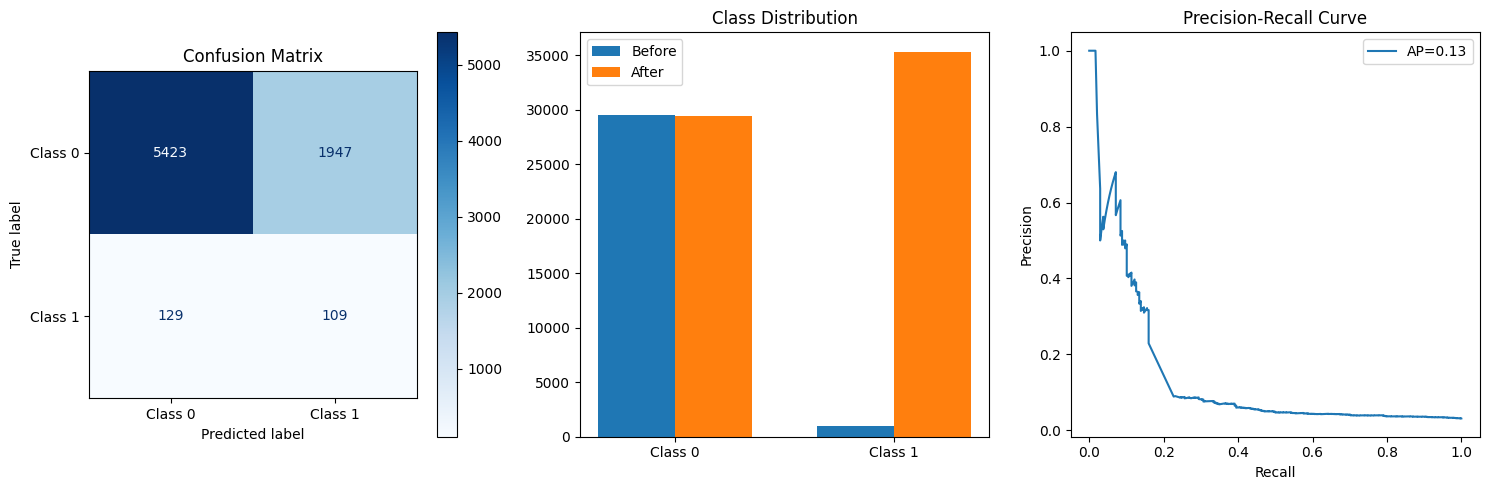


Top 20 Most Important Features:
      feature  importance
875        o2    0.049740
561      ccoc    0.043164
26        c1c    0.041477
317        cc    0.038005
318       cc1    0.035341
174  c2ccccc2    0.032546
251  c3ccccc3    0.028542
450       ccc    0.026795
354     cc1cn    0.023243
851        nn    0.022778
575        cl    0.021989
580        cn    0.021456
137       c2c    0.020496
880        oc    0.019516
858       nnc    0.018929
684        n1    0.017569
155      c2cc    0.016580
359      cc1n    0.015842
16         c1    0.014249
715      n2cc    0.013154


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt

# Load the dataset
data_path = '/content/hiv.csv'
data = pd.read_csv(data_path)

# Define features and target column
X_smiles = data['smiles']
y = data['label']

# Print initial class distribution
print("Initial class distribution:")
print(pd.Series(y).value_counts(normalize=True))

# Optimize CountVectorizer
vectorizer = CountVectorizer(
    max_features=1000,
    min_df=2,
    max_df=0.95,
    binary=True
)
X = vectorizer.fit_transform(X_smiles)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Use SMOTETomek for better balance
smote_tomek = SMOTETomek(
    sampling_strategy={0: sum(y_train == 0), 1: int(sum(y_train == 0) * 1.2)},  # Slightly oversampling class 1
    random_state=42
)
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train, y_train)

# Create RandomForestClassifier with balanced class weights
rf_model = RandomForestClassifier(
    n_estimators=200,    # Increased number of trees for better performance
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced_subsample',  # Use balanced weights
    n_jobs=-1,
    random_state=42
)

# Create cross-validation strategy with balanced folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation with multiple metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']
cv_scores = {}
for metric in scoring:
    scores = cross_val_score(
        rf_model,
        X_train_balanced,
        y_train_balanced,
        cv=cv,
        scoring=metric,
        n_jobs=-1
    )
    cv_scores[metric] = scores

# Print cross-validation results
for metric, scores in cv_scores.items():
    print(f"\n{metric.capitalize()} CV scores: {scores}")
    print(f"Mean {metric}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# Train the final model
rf_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plot results
plt.figure(figsize=(15, 5))

# Plot 1: Confusion Matrix
plt.subplot(131)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("Confusion Matrix")

# Plot 2: Class Distribution Before and After Balancing
plt.subplot(132)
width = 0.35
x = np.arange(2)
plt.bar(x - width/2, [sum(y_train == 0), sum(y_train == 1)], width, label='Before')
plt.bar(x + width/2, [sum(y_train_balanced == 0), sum(y_train_balanced == 1)], width, label='After')
plt.xticks(x, ['Class 0', 'Class 1'])
plt.legend()
plt.title("Class Distribution")

# Plot 3: Precision-Recall Curve
plt.subplot(133)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)
plt.plot(recall, precision, label=f'AP={avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Print feature importance for top 20 features
feature_names = vectorizer.get_feature_names_out()
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
})
print("\nTop 20 Most Important Features:")
print(feature_importance.sort_values('importance', ascending=False).head(20))

Initial class distribution:
label
0    36852
1     1188
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validatio


Accuracy CV scores: [0.80258927 0.80242004 0.80081232 0.79810459 0.80665087]
Mean accuracy: 0.8021 (+/- 0.0056)

Precision CV scores: [0.7619743  0.76689491 0.7659511  0.7589338  0.76605706]
Mean precision: 0.7640 (+/- 0.0061)

Recall CV scores: [0.88127006 0.87012329 0.86761229 0.87504222 0.88416076]
Mean recall: 0.8756 (+/- 0.0126)

F1 CV scores: [0.81729188 0.81525437 0.81361837 0.81286275 0.82088265]
Mean f1: 0.8160 (+/- 0.0058)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.73      0.83      7370
           1       0.05      0.41      0.08       238

    accuracy                           0.72      7608
   macro avg       0.51      0.57      0.46      7608
weighted avg       0.95      0.72      0.81      7608


ROC AUC Score: 0.6048


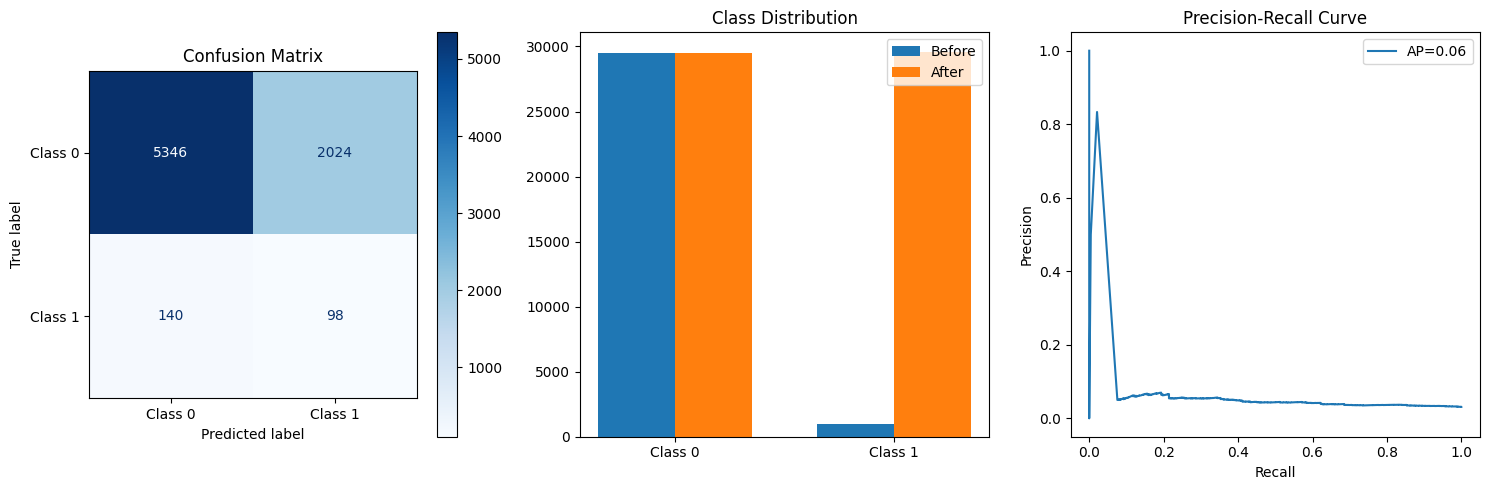


Final class distribution in training data:
label
1    29608
0    29482
Name: count, dtype: int64


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt

# Load the dataset
data_path = '/content/hiv.csv'
data = pd.read_csv(data_path)

# Define features and target column
X_smiles = data['smiles']
y = data['label']

# Print initial class distribution
print("Initial class distribution:")
print(pd.Series(y).value_counts())

# Optimize CountVectorizer with more features
vectorizer = CountVectorizer(
    max_features=2000,  # Increased features for better discrimination
    min_df=1,          # Include more rare features
    max_df=0.98,
    binary=True
)
X = vectorizer.fit_transform(X_smiles)

# Split the dataset with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# First apply SMOTE with aggressive oversampling for class 1
smote = SMOTE(
    sampling_strategy={0: sum(y_train == 0), 1: 4000},  # Target 4000 samples for class 1
    random_state=42,
    k_neighbors=5
)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Then apply ADASYN to add more diverse synthetic samples
adasyn = ADASYN(
    sampling_strategy='auto',
    random_state=42,
    n_neighbors=5
)
X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train_smote, y_train_smote)

# Create RandomForestClassifier with enhanced parameters
rf_model = RandomForestClassifier(
    n_estimators=300,    # Increased trees for better learning
    max_depth=20,        # Deeper trees for complex patterns
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight='balanced',  # Use balanced weights
    n_jobs=-1,
    random_state=42
)

# Create cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation with multiple metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']
cv_scores = {}
for metric in scoring:
    scores = cross_val_score(
        rf_model,
        X_train_balanced,
        y_train_balanced,
        cv=cv,
        scoring=metric,
        n_jobs=-1
    )
    cv_scores[metric] = scores

# Print cross-validation results
for metric, scores in cv_scores.items():
    print(f"\n{metric.capitalize()} CV scores: {scores}")
    print(f"Mean {metric}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# Train the final model
rf_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plot results
plt.figure(figsize=(15, 5))

# Plot 1: Confusion Matrix
plt.subplot(131)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("Confusion Matrix")

# Plot 2: Class Distribution Before and After Balancing
plt.subplot(132)
width = 0.35
x = np.arange(2)
plt.bar(x - width/2, [sum(y_train == 0), sum(y_train == 1)], width, label='Before')
plt.bar(x + width/2, [sum(y_train_balanced == 0), sum(y_train_balanced == 1)], width, label='After')
plt.xticks(x, ['Class 0', 'Class 1'])
plt.legend()
plt.title("Class Distribution")

# Plot 3: Precision-Recall Curve
plt.subplot(133)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)
plt.plot(recall, precision, label=f'AP={avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Print final class distribution
print("\nFinal class distribution in training data:")
print(pd.Series(y_train_balanced).value_counts())

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt

# Load the dataset
data_path = '/content/hiv.csv'
data = pd.read_csv(data_path)

# Define features and target column
X_smiles = data['smiles']
y = data['label']

# Print initial class distribution
print("Initial class distribution:")
print(pd.Series(y).value_counts())

# Optimize CountVectorizer
vectorizer = CountVectorizer(
    max_features=1500,
    min_df=2,
    max_df=0.95,
    binary=True
)
X = vectorizer.fit_transform(X_smiles)

# Split with a smaller test size to have more training data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# Use SMOTE with very aggressive oversampling for class 1
smote = SMOTE(
    sampling_strategy={0: sum(y_train == 0), 1: sum(y_train == 0) * 0.9},  # Make class 1 90% of class 0
    random_state=42,
    k_neighbors=3  # Reduced for more focused sampling
)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Create RandomForestClassifier with optimized parameters for class 1
rf_model = RandomForestClassifier(
    n_estimators=500,    # More trees
    max_depth=25,        # Deeper trees
    min_samples_split=3,
    min_samples_leaf=1,  # Allows for more specific leaf nodes
    class_weight={0: 1, 1: 2},  # Give more weight to class 1
    max_features='sqrt',  # Better feature selection
    n_jobs=-1,
    random_state=42
)

# Train the model
print("Training model...")
rf_model.fit(X_train_balanced, y_train_balanced)

# Make predictions with adjusted threshold
y_pred_proba = rf_model.predict_proba(X_test)
# Lower threshold for class 1 prediction to increase true positives
threshold = 0.3  # Adjusted threshold favoring class 1
y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plot results
plt.figure(figsize=(15, 5))

# Plot 1: Confusion Matrix
plt.subplot(131)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("Confusion Matrix")

# Plot 2: Class Distribution Before and After Balancing
plt.subplot(132)
width = 0.35
x = np.arange(2)
plt.bar(x - width/2, [sum(y_train == 0), sum(y_train == 1)], width, label='Before')
plt.bar(x + width/2, [sum(y_train_balanced == 0), sum(y_train_balanced == 1)], width, label='After')
plt.xticks(x, ['Class 0', 'Class 1'])
plt.legend()
plt.title("Class Distribution")

# Plot 3: Precision-Recall Curve with Threshold
plt.subplot(133)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])
avg_precision = average_precision_score(y_test, y_pred_proba[:, 1])
plt.plot(recall, precision, label=f'AP={avg_precision:.2f}')
plt.axvline(x=recall[np.argmin(np.abs(thresholds - threshold))], color='r', linestyle='--', label=f'Threshold={threshold}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Print feature importance for top 10 features
feature_names = vectorizer.get_feature_names_out()
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
})
print("\nTop 10 Most Important Features:")
print(feature_importance.sort_values('importance', ascending=False).head(10))

# Print final distributions
print("\nFinal class distribution in training data:")
print(pd.Series(y_train_balanced).value_counts())
print("\nPredicted class distribution in test data:")
print(pd.Series(y_pred).value_counts())

Initial class distribution:
label
0    36852
1     1188
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


TypeError: expected a sequence of integers or a single integer, got '27181.600000000002'

Initial class distribution:
label
0    36852
1     1188
Name: count, dtype: int64
Target number of samples for class 1: 28191
Training model...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.08      0.14      5528
           1       0.03      0.97      0.06       178

    accuracy                           0.10      5706
   macro avg       0.51      0.52      0.10      5706
weighted avg       0.96      0.10      0.14      5706


ROC AUC Score: 0.6498


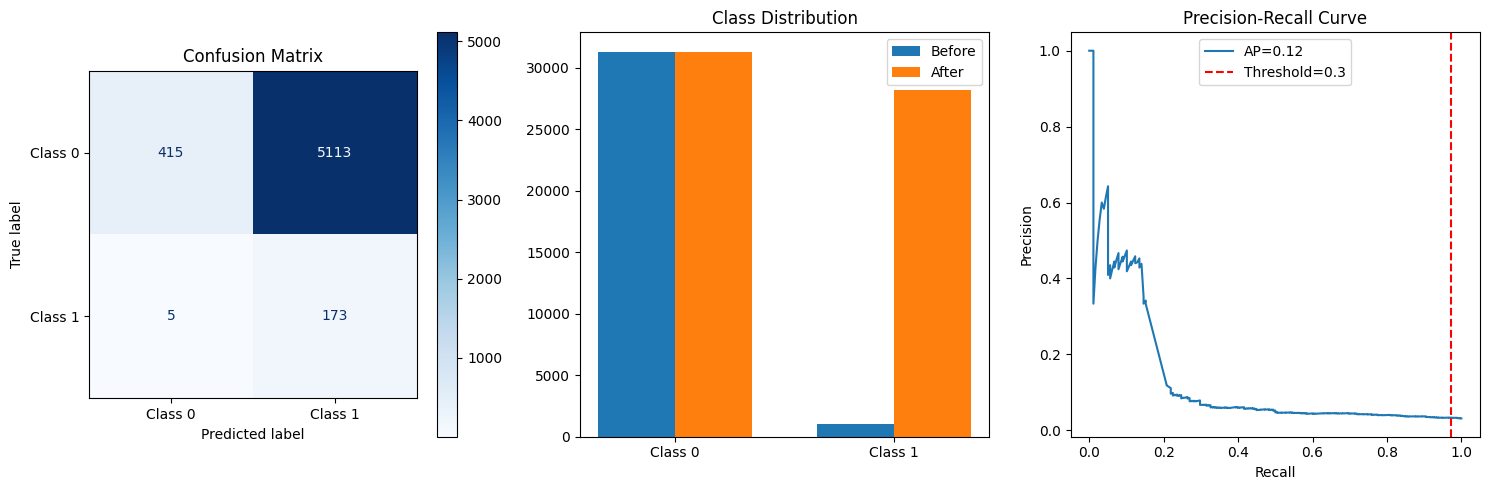


Final class distribution in training data:
label
0    31324
1    28191
Name: count, dtype: int64

Predicted class distribution in test data:
1    5286
0     420
Name: count, dtype: int64


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load the dataset
data_path = '/content/hiv.csv'
data = pd.read_csv(data_path)

# Define features and target column
X_smiles = data['smiles']
y = data['label']

# Print initial class distribution
print("Initial class distribution:")
print(pd.Series(y).value_counts())

# Optimize CountVectorizer
vectorizer = CountVectorizer(
    max_features=1500,
    min_df=2,
    max_df=0.95,
    binary=True
)
X = vectorizer.fit_transform(X_smiles)

# Split with a smaller test size to have more training data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# Calculate sampling strategy with proper integer values
n_class0 = sum(y_train == 0)
n_class1_target = int(n_class0 * 0.9)  # Convert to integer

print(f"Target number of samples for class 1: {n_class1_target}")

# Use SMOTE with integer sampling strategy
smote = SMOTE(
    sampling_strategy={0: n_class0, 1: n_class1_target},
    random_state=42,
    k_neighbors=3
)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Create RandomForestClassifier with optimized parameters
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=25,
    min_samples_split=3,
    min_samples_leaf=1,
    class_weight={0: 1, 1: 2},
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

# Train the model
print("Training model...")
rf_model.fit(X_train_balanced, y_train_balanced)

# Make predictions with adjusted threshold
y_pred_proba = rf_model.predict_proba(X_test)
threshold = 0.3
y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Plot results
plt.figure(figsize=(15, 5))

# Plot 1: Confusion Matrix
plt.subplot(131)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("Confusion Matrix")

# Plot 2: Class Distribution Before and After Balancing
plt.subplot(132)
width = 0.35
x = np.arange(2)
plt.bar(x - width/2, [sum(y_train == 0), sum(y_train == 1)], width, label='Before')
plt.bar(x + width/2, [sum(y_train_balanced == 0), sum(y_train_balanced == 1)], width, label='After')
plt.xticks(x, ['Class 0', 'Class 1'])
plt.legend()
plt.title("Class Distribution")

# Plot 3: Precision-Recall Curve with Threshold
plt.subplot(133)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])
avg_precision = average_precision_score(y_test, y_pred_proba[:, 1])
plt.plot(recall, precision, label=f'AP={avg_precision:.2f}')
plt.axvline(x=recall[np.argmin(np.abs(thresholds - threshold))], color='r', linestyle='--', label=f'Threshold={threshold}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Print distributions
print("\nFinal class distribution in training data:")
print(pd.Series(y_train_balanced).value_counts())
print("\nPredicted class distribution in test data:")
print(pd.Series(y_pred).value_counts())